In [1]:
from google.colab import drive
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import missingno as msno
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split

pd.set_option('display.max_columns', 1000)

# Define bivariate Gini (2*AUC - 1)
def gini_with_target(df, var, target='Retained'):
    try:
        if df[var].nunique() < 2:
            return 0
        auc = roc_auc_score(df[target], df[var])
        return 2 * auc - 1
    except:
        return 0

# Mount Google Drive
drive.mount('/content/drive')

# File paths
file_path1 = "/content/drive/MyDrive/Machine_Learning_project/sales_model.csv"
file_path2 = "/content/drive/MyDrive/Machine_Learning_project/crm_model.csv"
file_path3 = "/content/drive/MyDrive/Machine_Learning_project/finance_model.csv"

# Load data
df_sales = pd.read_csv(file_path1, decimal=',')
df_crm = pd.read_csv(file_path2, decimal=',')
df_finance = pd.read_csv(file_path3, decimal=',')

# Drop unused column
dropped_columns = ['GroupGradeType']

# Mark categorical variables using pd.Categorical
categorical_sales = ['Travel_Type', 'SPR_Product_Type', 'GroupGradeTypeLow', 'GroupGradeTypeHigh', 'MajorProgramCode']
for col in categorical_sales:
    df_sales[col] = pd.Categorical(df_sales[col])

# Ordinal mappings
grade_mapping = {'Undefined': 0, 'Elementary': 1, 'Middle': 2, 'High': 3}
size_mapping = {'nan': 0, 'S': 1, 'S-M': 2, 'M-L': 3, 'L': 4}
poverty_map = {'A': 0,'B': 1,'C': 2,'D': 3,'E': -1, '0': -2}

# Ordinal encoding for CRM
df_crm['Poverty_Code'] = df_crm['Poverty_Code'].map(poverty_map).fillna(-3)
df_crm['SchoolGradeTypeLow'] = df_crm['SchoolGradeTypeLow'].map(grade_mapping)
df_crm['SchoolGradeTypeHigh'] = df_crm['SchoolGradeTypeHigh'].map(grade_mapping)
df_crm['SchoolSizeIndicator'] = df_crm['SchoolSizeIndicator'].map(size_mapping)

# Nominal categorical
df_crm['School_Type'] = pd.Categorical(df_crm['School_Type'])

# Finance categorical
df_finance['Special_Pay'] = pd.Categorical(df_finance['Special_Pay'])

# Create join key
df_crm['ID_JOIN'] = df_crm['ID_CRM'].astype(str).str.extract(r'(\d+)', expand=False).str.zfill(5)
df_finance['ID_JOIN'] = df_finance['ID_FINANCE'].astype(str).str.extract(r'(\d+)', expand=False).str.zfill(5)
df_sales['ID_JOIN'] = df_sales['ID_SALES'].astype(str).str.extract(r'(\d+)', expand=False).str.zfill(5)


# Remove duplicates
df_crm = df_crm.drop_duplicates(subset='ID_JOIN', keep='last')
df_finance = df_finance.drop_duplicates(subset='ID_JOIN', keep='last')
df_sales = df_sales.drop_duplicates(subset='ID_JOIN', keep='last')

# Merge all
merged_df = df_sales.merge(df_crm, on='ID_JOIN', how='left').merge(df_finance, on='ID_JOIN', how='left')

merged_df = merged_df.drop(columns=["ID_SALES", "ID_CRM", "ID_FINANCE"], errors='ignore')

Mounted at /content/drive


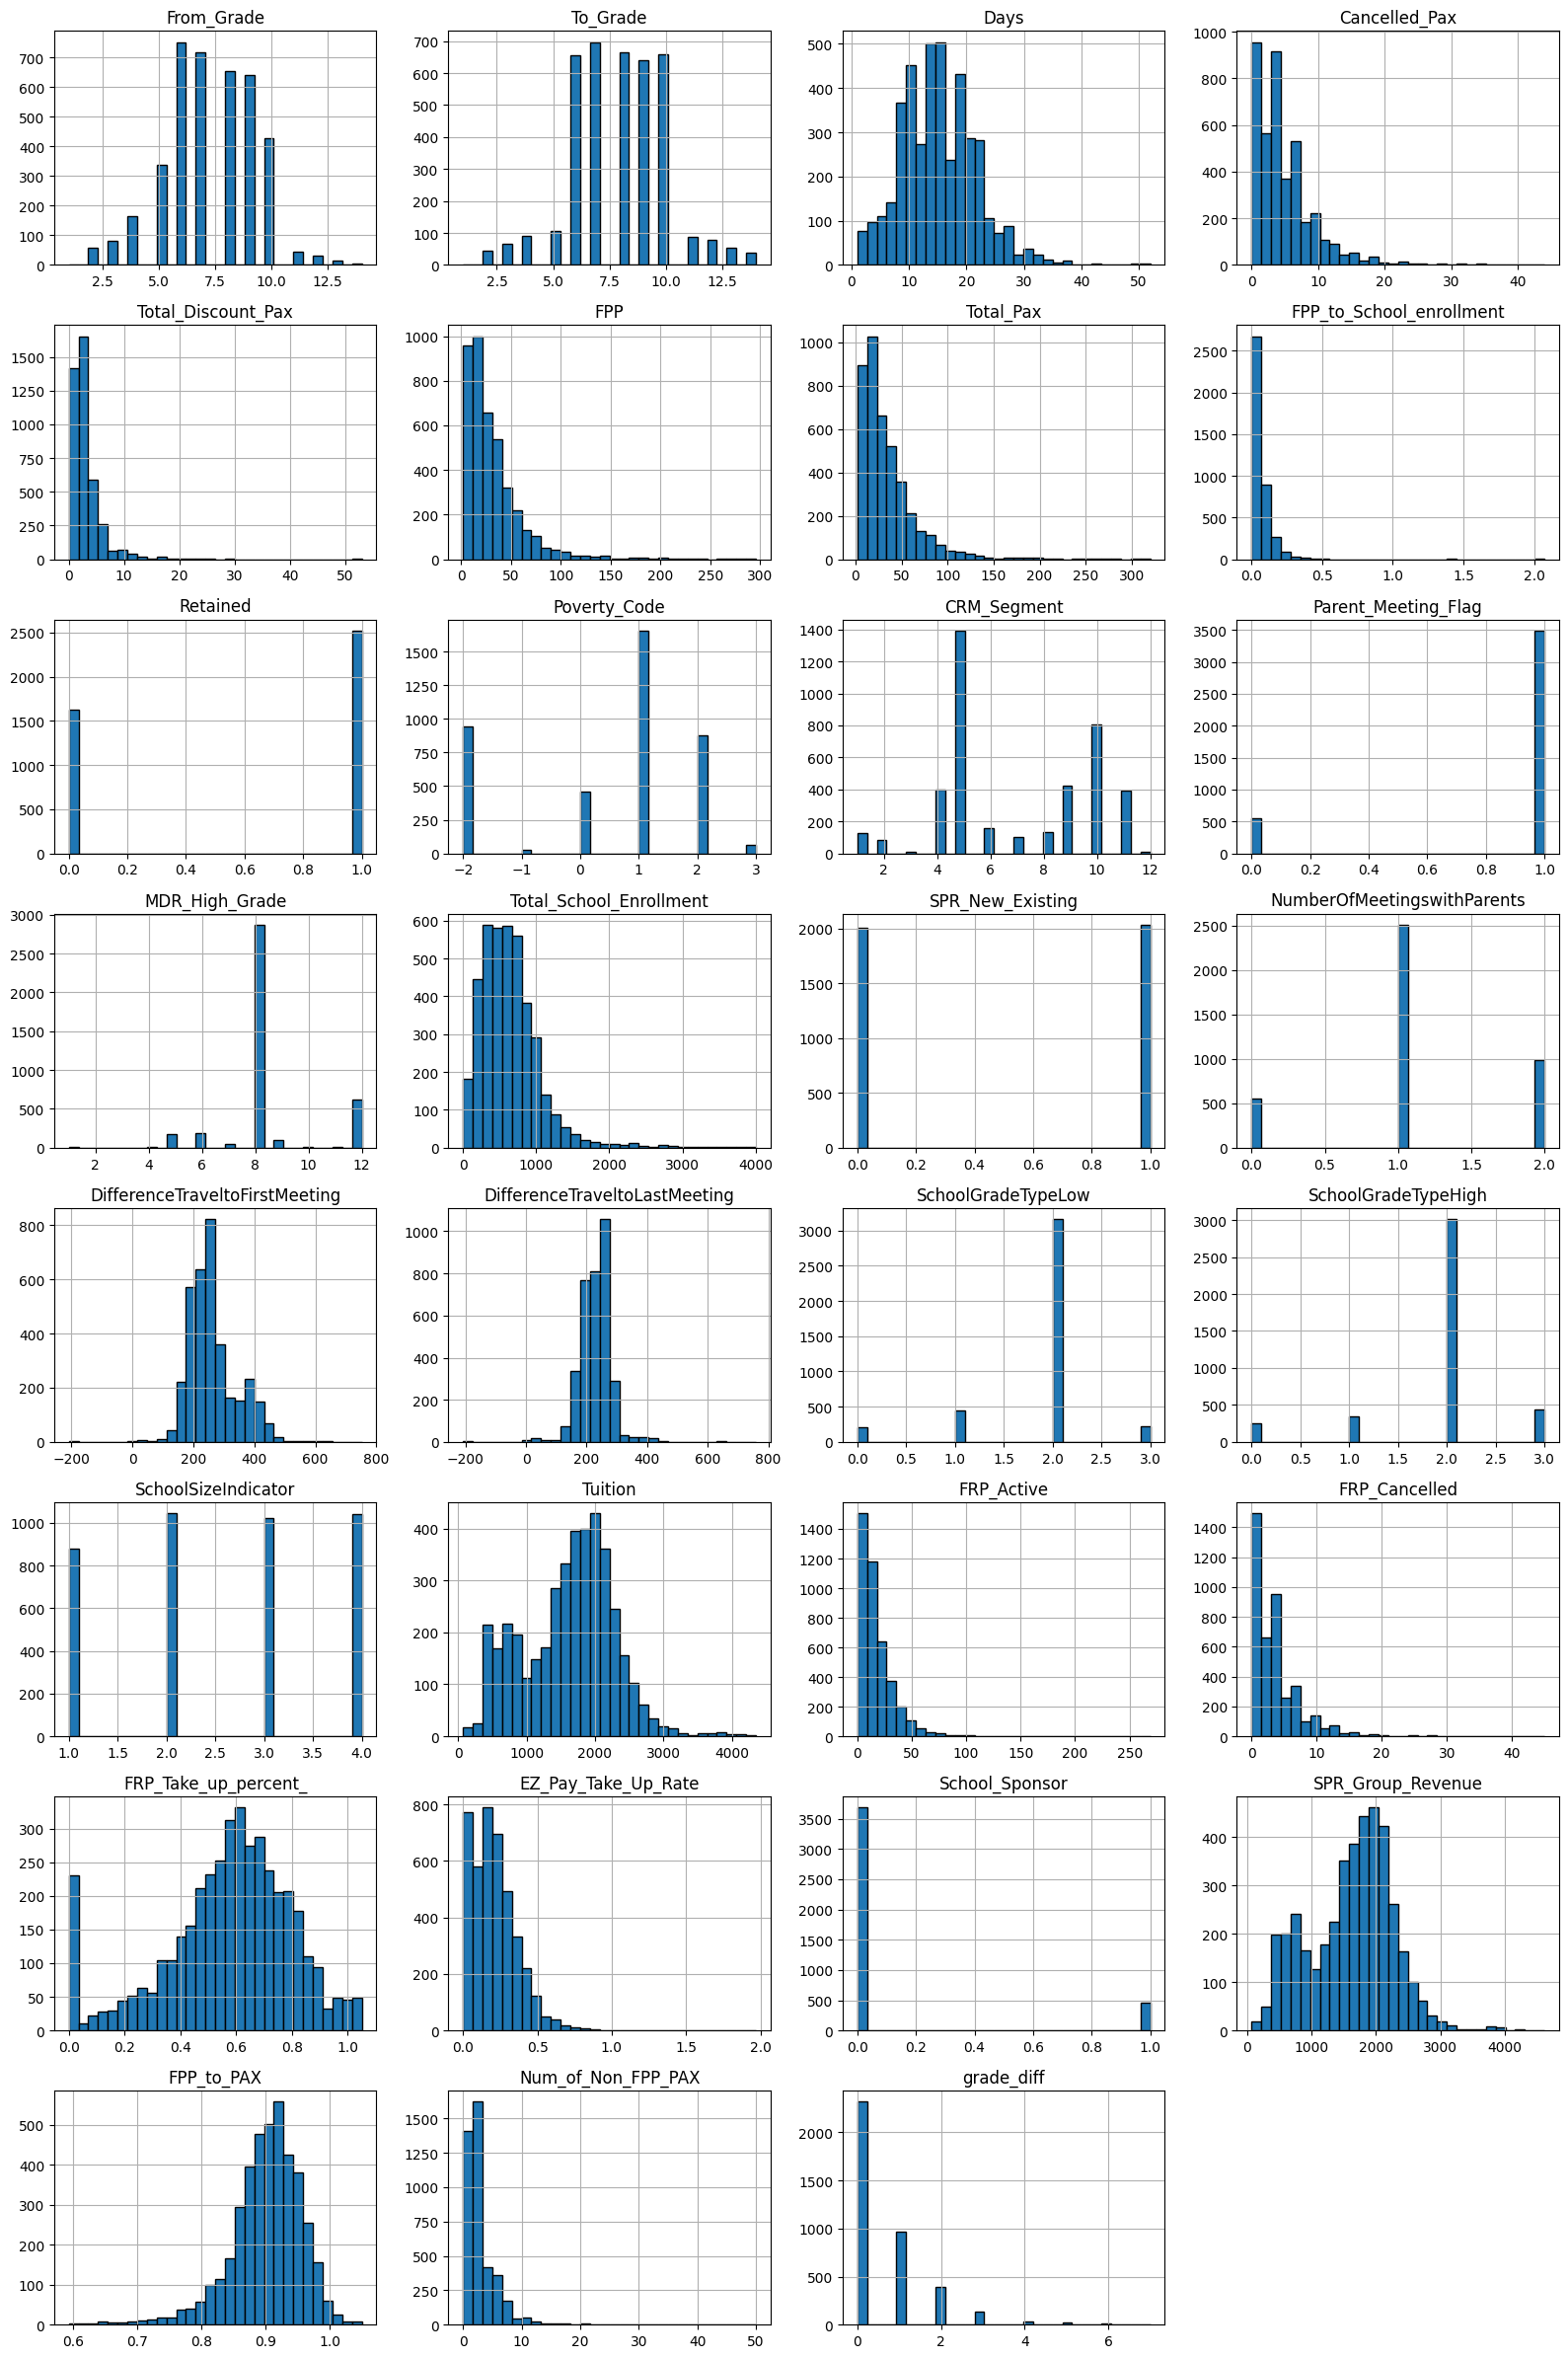

In [14]:
# Create a column that shows the span in school years of the groups that travaelled
merged_df['grade_diff'] = merged_df['To_Grade'] - merged_df['From_Grade']

# Select only continuous/numeric columns
numeric_cols = merged_df.select_dtypes(include=['float64', 'int64']).columns

# Set number of plots
n_cols = 4
n_rows = (len(numeric_cols) + n_cols - 1) // n_cols

# Plot histograms
plt.figure(figsize=(n_cols * 4, n_rows * 3))
for i, col in enumerate(numeric_cols):
    plt.subplot(n_rows, n_cols, i + 1)
    merged_df[col].hist(bins=30, edgecolor='black')
    plt.title(col)
    plt.tight_layout()

plt.show()

In [15]:
# Threshold: top 15 states kept, others grouped
top_states = merged_df['Group_State'].value_counts().nlargest(15).index
merged_df['Group_State'] = merged_df['Group_State'].apply(lambda x: x if x in top_states else 'Other')
merged_df['Group_State'] = merged_df['Group_State'].astype('category')

# Group rare Program_Code values
min_count = 40
program_counts = merged_df['Program_Code'].value_counts()
common_programs = program_counts[program_counts >= min_count].index

merged_df['Program_Code'] = merged_df['Program_Code'].apply(
    lambda x: x if x in common_programs else 'Rare_Program'
).astype("category")

# Define ordinal mapping for Income_Level (A–Q as increasing income brackets)
income_map = {val: idx for idx, val in enumerate(list("ABCDEFGHIJKLMNOPQ"), start=1)}
# Apply mapping; fallback to 0 for unexpected values like P1, P3, Z, etc.
merged_df['Income_Level'] = merged_df['Income_Level'].apply(lambda x: income_map.get(x, 0))

# Date feature engineering with cyclical encoding
date_cols = ['FirstMeeting', 'LastMeeting', 'Early_RPL', 'Latest_RPL',
             'Departure_Date', 'Return_Date', 'Initial_System_Date', 'Deposit_Date']

for col in date_cols:
    merged_df[col] = pd.to_datetime(merged_df[col], errors='coerce')

    # Extract month and weekday
    merged_df[f"{col}_month"] = merged_df[col].dt.month
    merged_df[f"{col}_weekday"] = merged_df[col].dt.weekday

    # Cyclical encoding
    merged_df[f"{col}_month_sin"] = np.sin(2 * np.pi * merged_df[f"{col}_month"] / 12)
    merged_df[f"{col}_month_cos"] = np.cos(2 * np.pi * merged_df[f"{col}_month"] / 12)

    merged_df[f"{col}_weekday_sin"] = np.sin(2 * np.pi * merged_df[f"{col}_weekday"] / 7)
    merged_df[f"{col}_weekday_cos"] = np.cos(2 * np.pi * merged_df[f"{col}_weekday"] / 7)

    # Optionally drop the original month & weekday columns
    merged_df.drop(columns=[col, f"{col}_month", f"{col}_weekday"], inplace=True)

# =============================
# Log transform skewed variables
# =============================
skewed_vars = ['Cancelled_Pax',
    'Total_Discount_Pax',
    'FPP',
    'Total_Pax',
    'FPP_to_School_enrollment',
    'Total_School_Enrollment',
    'Tuition',
    'FRP_Cancelled',
    'FRP Active',
    'EZ_Pay_Take_Up_Rate',
    'Num_of_Non_FPP_PAX',
    'DifferenceTraveltoFirstMeeting',
    'DifferenceTraveltoLastMeeting', 'grade_diff']
for col in skewed_vars:
    if col in merged_df.columns:
        merged_df[col] = merged_df[col].apply(lambda x: np.log1p(x) if pd.notnull(x) else x)



<ipython-input-15-c3bbb1b95163>:59: RuntimeWarning: invalid value encountered in log1p
  merged_df[col] = merged_df[col].apply(lambda x: np.log1p(x) if pd.notnull(x) else x)


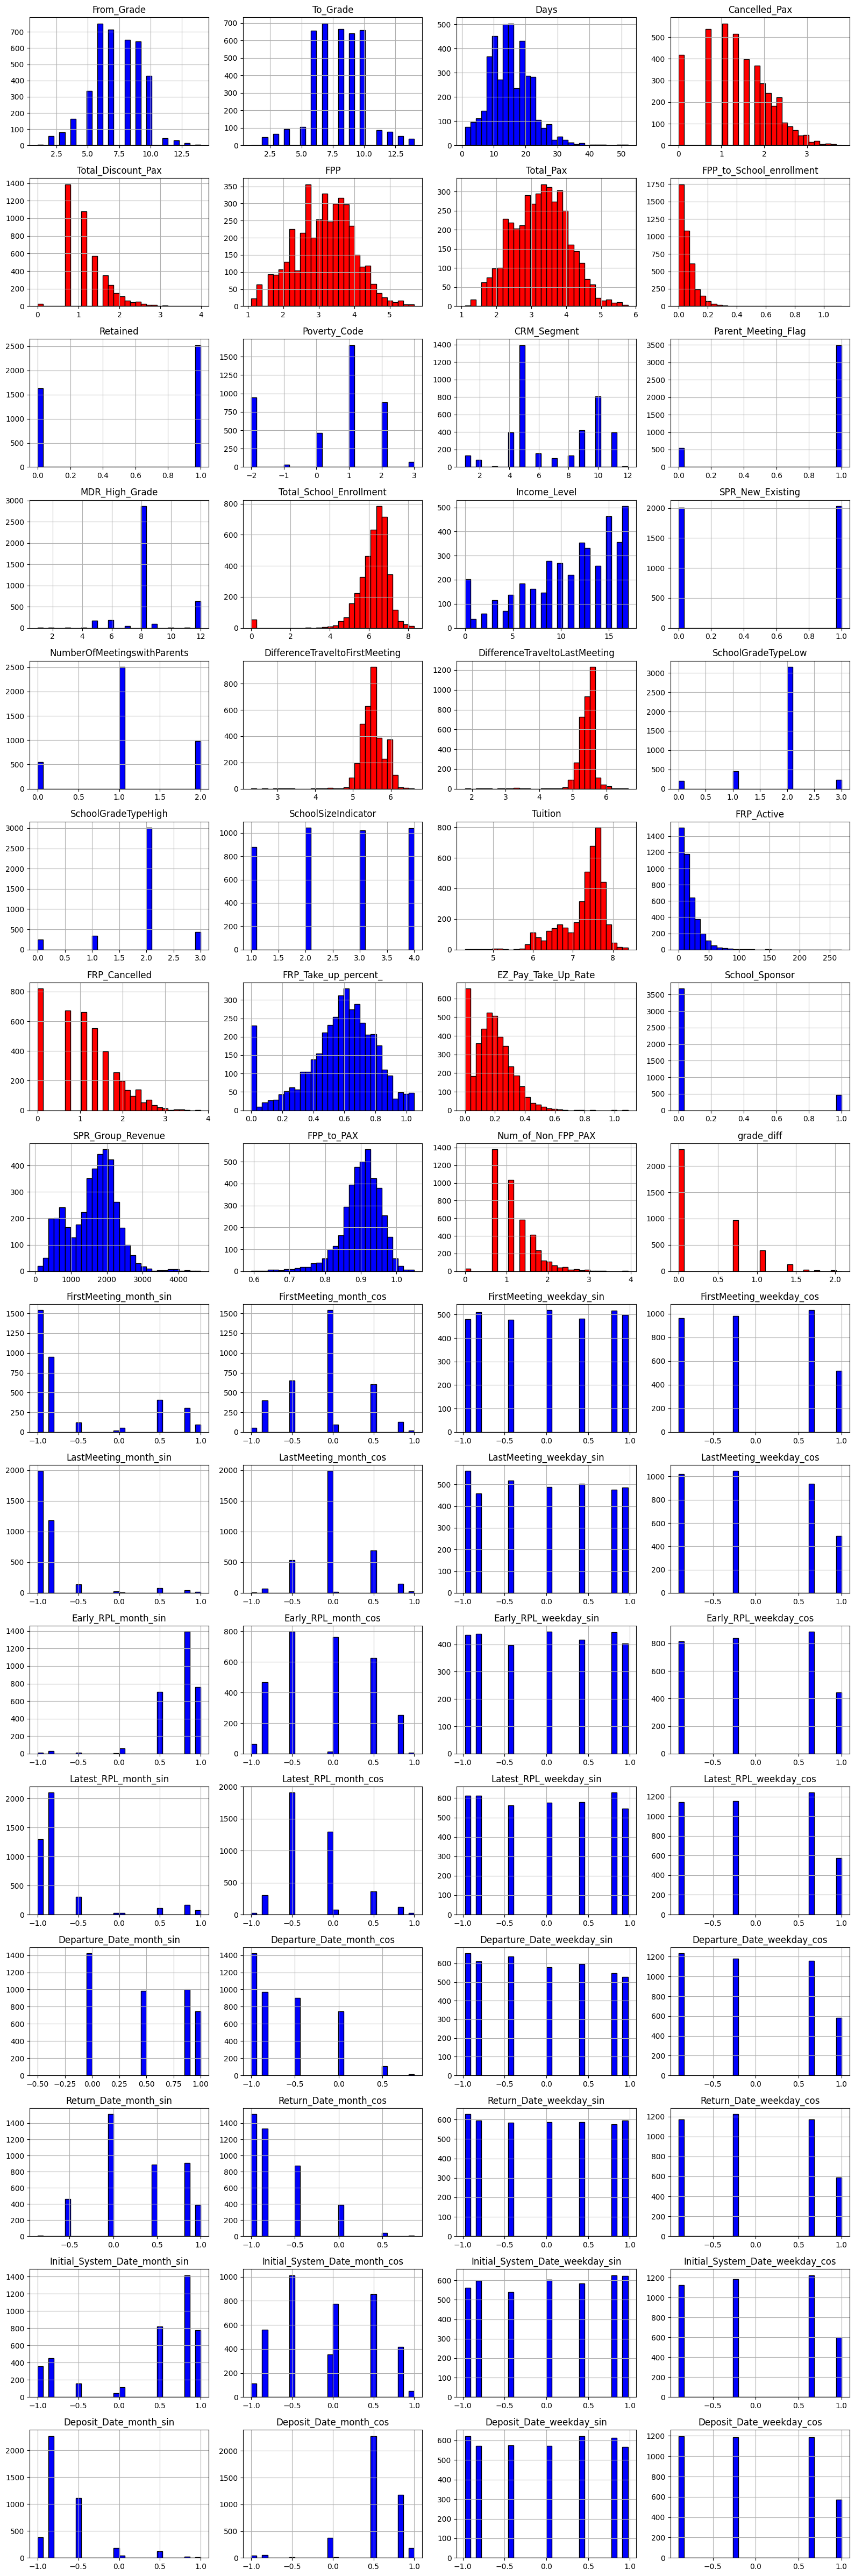

In [16]:
# Select only continuous/numeric columns
numeric_cols = merged_df.select_dtypes(include=['float64', 'int64']).columns

# Set number of plots
n_cols = 4
n_rows = (len(numeric_cols) + n_cols - 1) // n_cols

# Plot histograms
plt.figure(figsize=(n_cols * 4, n_rows * 3))
for i, col in enumerate(numeric_cols):
    plt.subplot(n_rows, n_cols, i + 1)
    color = 'red' if col in skewed_vars else 'blue'
    merged_df[col].hist(bins=30, edgecolor='black', color=color)
    plt.title(col)
    plt.tight_layout()

plt.show()
plt.show()

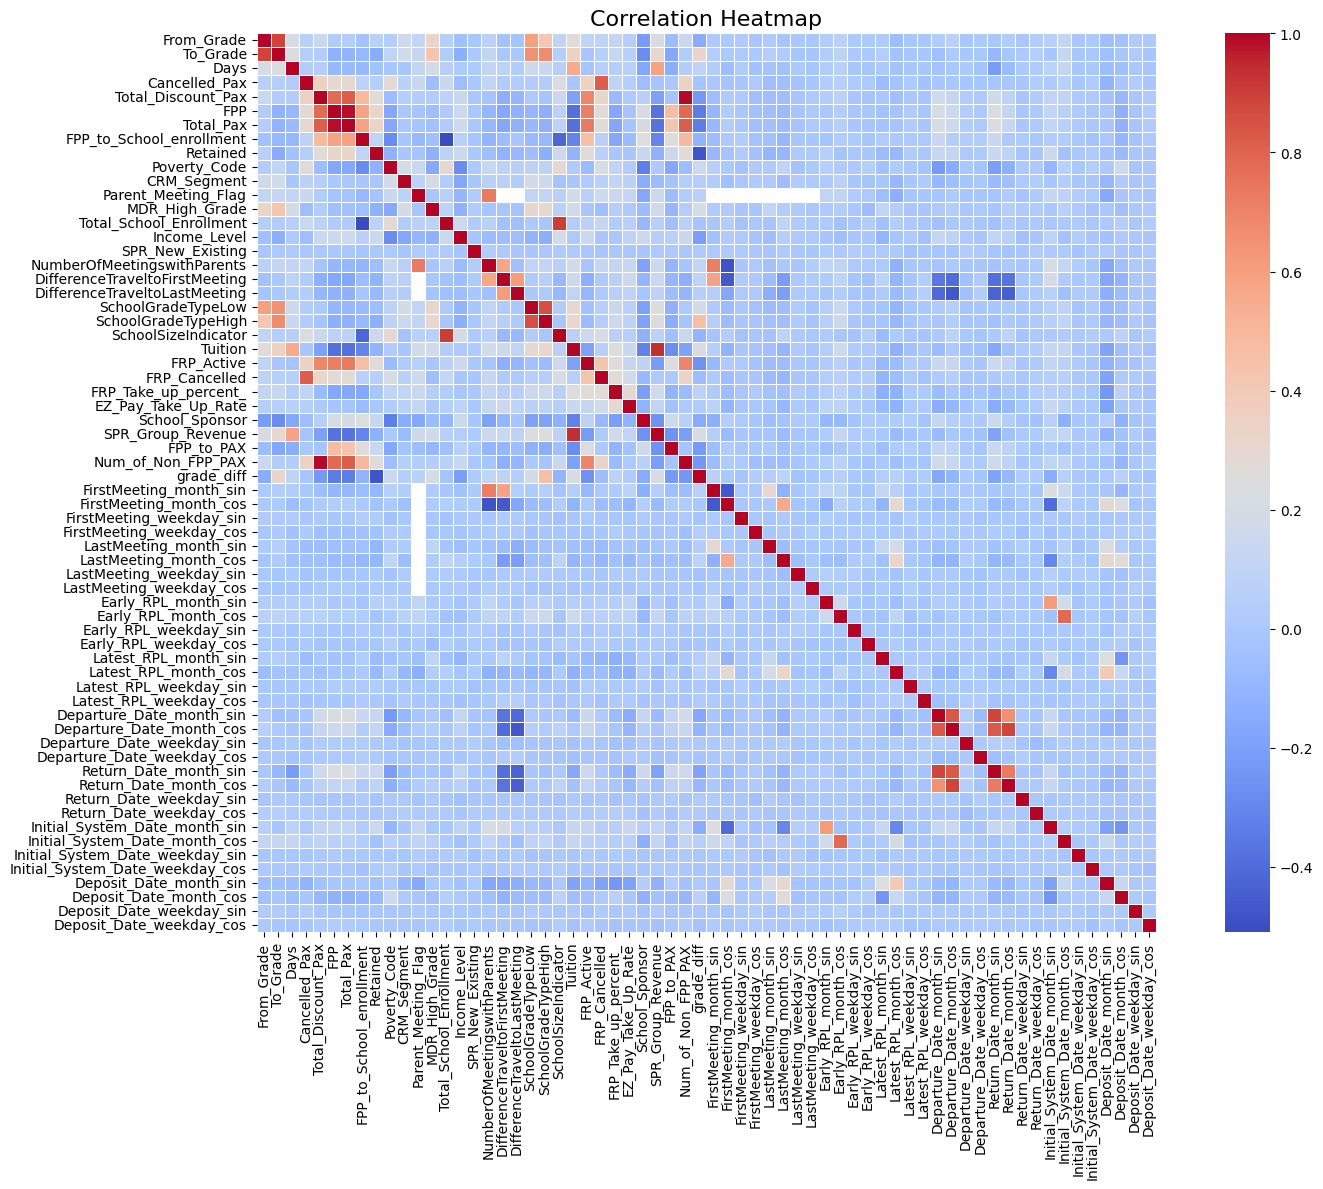

In [17]:
# ============================================
# Correlation matrix and high-correlation drop
# ============================================

# Select only numeric columns
numeric_df = merged_df.select_dtypes(include=['number'])

# Compute correlation matrix
corr_matrix = numeric_df.corr()

# Plot heatmap
plt.figure(figsize=(16, 12))
sns.heatmap(corr_matrix,
            cmap='coolwarm',
            annot=False,
            fmt=".2f",
            linewidths=0.5,
            cbar=True,
            square=True)

plt.title("Correlation Heatmap", fontsize=16)
plt.tight_layout()
plt.show()

In [18]:
# ============================================
# Correlation matrix and high-correlation drop
# ============================================

# Only numeric features for correlation matrix
numeric_df = merged_df.select_dtypes(include=[np.number])
corr_matrix = numeric_df.corr().abs()

# Track highly correlated pairs
corr_threshold = 0.8
high_corr_pairs = set()
for i in range(len(corr_matrix.columns)):
    for j in range(i):
        if corr_matrix.iloc[i, j] > corr_threshold:
            col1 = corr_matrix.columns[i]
            col2 = corr_matrix.columns[j]
            high_corr_pairs.add((col1, col2))

# Keep only the most predictive variable from each correlated pair
to_drop = []
for col1, col2 in high_corr_pairs:
    gini1 = gini_with_target(merged_df, col1)
    gini2 = gini_with_target(merged_df, col2)
    if gini1 < gini2:
        to_drop.append(col1)
    else:
        to_drop.append(col2)

# Drop less predictive columns
merged_df.drop(columns=list(set(to_drop)), inplace=True)

# Save as Parquet for CatBoost
output_catboost_path = "/content/drive/MyDrive/Machine_Learning_project/merged_dataset_catboost_ready.parquet"
merged_df.to_parquet(output_catboost_path, index=False)

# Also split and save train/test
train_df, test_df = train_test_split(merged_df, test_size=0.25, random_state=2025)
train_df.to_parquet("/content/drive/MyDrive/Machine_Learning_project/merged_dataset_catboost_train.parquet", index=False)
test_df.to_parquet("/content/drive/MyDrive/Machine_Learning_project/merged_dataset_catboost_test.parquet", index=False)


In [19]:
high_corr_pairs

{('Departure_Date_month_cos', 'Departure_Date_month_sin'),
 ('FRP_Cancelled', 'Cancelled_Pax'),
 ('Num_of_Non_FPP_PAX', 'Total_Discount_Pax'),
 ('Num_of_Non_FPP_PAX', 'Total_Pax'),
 ('Return_Date_month_cos', 'Departure_Date_month_cos'),
 ('Return_Date_month_sin', 'Departure_Date_month_cos'),
 ('Return_Date_month_sin', 'Departure_Date_month_sin'),
 ('SPR_Group_Revenue', 'Tuition'),
 ('SchoolGradeTypeHigh', 'SchoolGradeTypeLow'),
 ('SchoolSizeIndicator', 'Total_School_Enrollment'),
 ('To_Grade', 'From_Grade'),
 ('Total_Pax', 'FPP'),
 ('Total_Pax', 'Total_Discount_Pax')}

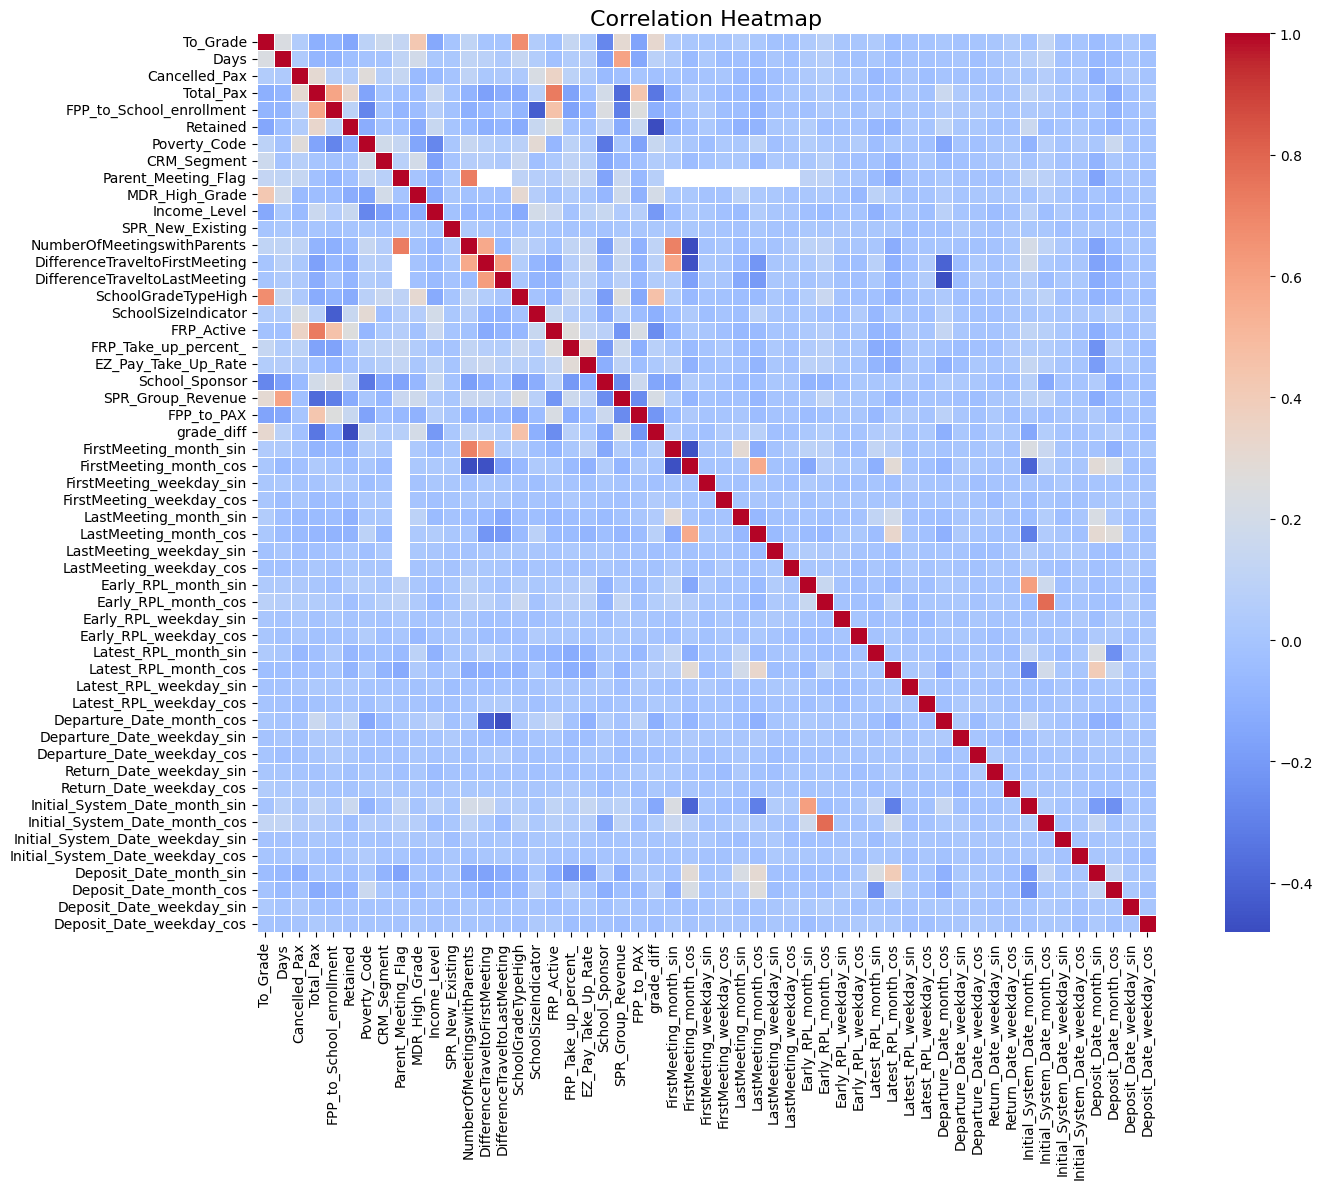

In [20]:
# Select only numeric columns
numeric_df = merged_df.select_dtypes(include=['number'])

# Compute correlation matrix
corr_matrix = numeric_df.corr()

# Plot heatmap
plt.figure(figsize=(16, 12))
sns.heatmap(corr_matrix,
            cmap='coolwarm',
            annot=False,
            fmt=".2f",
            linewidths=0.5,
            cbar=True,
            square=True)

plt.title("Correlation Heatmap", fontsize=16)
plt.tight_layout()
plt.show()

In [21]:
# Save as Parquet for CatBoost
output_catboost_path = "/content/drive/MyDrive/Machine_Learning_project/merged_dataset_catboost_ready.parquet"
merged_df.to_parquet(output_catboost_path, index=False)

# Also split and save train/test
train_df, test_df = train_test_split(merged_df, test_size=0.25, random_state=2025)
train_df.to_parquet("/content/drive/MyDrive/Machine_Learning_project/merged_dataset_catboost_train.parquet", index=False)
test_df.to_parquet("/content/drive/MyDrive/Machine_Learning_project/merged_dataset_catboost_test.parquet", index=False)

In [22]:
# Detect all object columns and convert them to categorical
cat_features = merged_df.select_dtypes(include=["category"]).columns.tolist()
object_cols = merged_df.select_dtypes(include="object").columns

for col in object_cols:
    merged_df[col] = merged_df[col].astype("category")

# Update cat_features list
cat_features = list(set(cat_features + object_cols.tolist()))

# 🔍 Count number of unique categories per categorical column
category_counts = {col: merged_df[col].nunique() for col in cat_features}

# Display sorted result
category_counts_sorted = dict(sorted(category_counts.items(), key=lambda item: item[1], reverse=True))
for col, count in category_counts_sorted.items():
    print(f"{col}: {count} categories")

ID_JOIN: 4153 categories
Group_State: 16 categories
GroupGradeType: 13 categories
MDR_Low_Grade: 13 categories
Program_Code: 12 categories
SchoolGradeType: 9 categories
Region: 6 categories
SPR_Product_Type: 6 categories
GroupGradeTypeLow: 6 categories
Special_Pay: 4 categories
School_Type: 4 categories
MajorProgramCode: 4 categories
GroupGradeTypeHigh: 4 categories
Travel_Type: 3 categories
DepartureMonth: 2 categories
